<a href="https://colab.research.google.com/github/MelissaMarin/Deep-Learning/blob/main/SEGUNDO%20CORTE/feelings_on_twitter_LMMF01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os            #  trabajar sobre el sistema operativo
import tweepy as tw
import numpy as np
import pandas as pd

##0. Cargamos el CCv del corpus de google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##1. Configuración de la API de twitter

In [ ]:
consumer_key= 'GiXlxIxBiMIwLpCcIjTzvrfEN'
consumer_secret= 'Ed4Xmj5FsWcGDzhqhze8QT18pMBhWF6v0G6ibeEPxsNLimZ1aQ'
access_token= '1388268774843949057-fHWaT3c6YozANTSrrrKNG1cV9vc7mx'
access_token_secret= 'Zm0KAjt05aClmjGq8Yr5kLjpSLTSrOB3P9d2GyjbHD5Kv'

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

##2. Publicar un tweet

In [ ]:
api.update_status('#USTATUNJA im happy')

Status(_api=<tweepy.api.API object at 0x7fadd75cb590>, _json={'created_at': 'Tue May 04 02:56:08 +0000 2021', 'id': 1389413504344489985, 'id_str': '1389413504344489985', 'text': '#USTATUNJA im happy', 'truncated': False, 'entities': {'hashtags': [{'text': 'USTATUNJA', 'indices': [0, 10]}], 'symbols': [], 'user_mentions': [], 'urls': []}, 'source': '<a href="https://help.twitter.com/en/using-twitter/how-to-tweet#source-labels" rel="nofollow">usta_machineLearning</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 1388268774843949057, 'id_str': '1388268774843949057', 'name': 'Melissa Marin Fajardo', 'screen_name': 'MelissaMarinFa1', 'location': '', 'description': 'Ingeniería de Sistemas de la Universidad Santo Tomas Seccional Tunja', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 1, 'friends_count': 4, 'listed_co

##3. Obtener la data de Twitter

In [ ]:
# Definir el termino de la busqueda y la fecha de inicio
search_words ='#DuqueAsesino'
date_since ='2021-01-05'
#para que no tome los tweets que estan retweets
new_search = search_words+" -filter:retweets"
new_search
# Collecional tweets
tweets = tw.Cursor(api.search,new_search,"es",date_since).items(2000)


In [ ]:
#[tweet.text for tweet in tweets]

##4. Pasar los tweets a un dataFrame

In [ ]:
data_frame = [[tweet.user.screen_name, tweet.user.location,tweet.text] for tweet in tweets]
tw_dataframe = pd.DataFrame(data= data_frame , columns=["user","location","text"])
tw_dataframe
#guardamos el dataframe en un CSV
tw_dataframe.to_csv('/content/drive/MyDrive/Colab Notebooks/Database DuqueAsesino.csv', index=False, encoding='utf-8')

In [ ]:
tw_dataframe.head(1000)

,user,location,text
0,issapgonzalez,"Cartagena, Colombia",Nos están matando Y NO ES EL COVID. #DuqueAsesino
1,jiminiluvya,𝗌𝗁𝖾,xfavor las personas q vayan a la marcha lleven...
2,Valenti58930027,,#UribeSomosTodos\n#YoApoyoAlEsmad\n#YoApoyoALa...
3,CapazMauricio1,Santander de Quilichao,@alejo_95115 @UEenColombia @CIDH @WOLA_org @Co...
4,MaryOrozcoP,Santa Marta - Magdalena,"Que lo expliquen con plastilina, porque yo tam..."
...,...,...,...
995,CaterineMarquez,,@petrogustavo Nada que podemos tocar el suelgo...
996,Arceniano,Dictadura Colombiana,A reportar al Matarife\n#ParoIndefinido2021\n#...
997,CaterineMarquez,,@IvanCepedaCast Nada que podemos tocar el suel...
998,ms_hm27,,#DuqueAsesino\nMedellín https://t.co/EpYVQrP09Y


##ANALIZANDO SENTIMIENTOS DE LOS TWEETS


### P0. Obtener corpus : Convirtiendo XML a CSV 

In [ ]:
#librerias necesarias
import xml.etree.ElementTree as etree
import csv
from os import scandir
from sklearn.model_selection import train_test_split

#### Funcion para listar archivos de un directorio

In [ ]:
# importing os module  
import os 
#listado_de_archivos_desde_un_path
def files_of_path(path): 
    return [obj.name for obj in os.scandir(path) if obj.is_file()]
    
files= files_of_path("/content/drive/MyDrive/Colab Notebooks/Database Twetter/Tass 2017")
for file in files:
    print(file)

####función para convertir listas en archivos CSV

In [ ]:

def list_to_csv(data, filename):
  with open(filename, 'w', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile, delimiter=',', lineterminator='\n', quoting=csv.QUOTE_NONNUMERIC)
    writer.writerows(data)

####función para cargar de un CSV a una LISTA (messages | labels)

In [ ]:
def csv_to_lists(filename):
  messages = []
  labels = []
  with open(filename, 'r', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      messages.append(row[1])
      labels.append(row[2])
  return messages, labels

####funciones para prasear xml en un dataframe

#####corpus de general tweetid | content | sentiments/polarity/value

In [ ]:
def general_tass_2017_to_list(filename,qrel=None):
  tree = etree.parse(filename)
  root = tree.getroot()
  data = []

  for tweet in root:
    tweetId = tweet.find('tweetid').text
    content = tweet.find('content').text
    polarityValue = qrel[tweetId]
    data.append([tweetId, content.replace('\n',' '), polarityValue])

  return data

#####Corpus politics tweetid | content | sentiments/polarity

In [ ]:
def politics_tass_to_list(filename):
  tree = etree.parse(filename)
  root = tree.getroot()
  data = []

  for tweet in root:
    tweetId = tweet.find('tweetid').text
    content = tweet.find('content').text
    aux = next((e for e in tweet.findall('sentiments/polarity') if e.find('entity') == None), None)
    if aux != None:
      polarityValue = aux.find('value').text
      data.append([tweetId, content.replace('\n',' '), polarityValue])
  return data

#####corpus de internacional tweetid | content | sentiments/polarity/value

In [ ]:
def intertass_tass_to_list(filename, qrel=None):
  tree = etree.parse(filename)
  root = tree.getroot()
  data = []

  for tweet in root:
    tweetId = tweet.find('tweetid').text
    content = tweet.find('content').text
    polarityValue = tweet.find('sentiment/polarity/value').text
    if polarityValue == None:
      polarityValue = qrel[tweetId]
      data.append([tweetId, content.replace('\n',' '), polarityValue])
  return data

####funcion para unir los tweets corpus general test con sus sentimientos

In [ ]:
#Listar los id tweets | sentiment :P (Positivo) - N (Negativo) - NEU (NEUtro) - NONE (sin sentimiento)
def gold_standard_to_dict(filename):
  with open(filename, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    data = {rows[0]: rows[1] for rows in reader}

  return data

####Función para separar el 100% del corpus entre: Train : 70% - Test: 30%

In [ ]:
def generate_train_test_subsets(data, size):
  codes = [d[0] for d in data]
  labels = [d[2] for d in data]
  codes_train, codes_test, labels_train, labels_test = train_test_split(codes, labels, train_size=size)
  train_data = [d for d in data if d[0] in codes_train]
  test_data = [d for d in data if d[0] in codes_test]
  return train_data, test_data

####Ejecutar cada función de parsear los corpus y guardarlo en un CSV (full, train, test)

In [ ]:
data = []

#Parceamos el internacional TASS
#tomamos el corpus internacional (test) y generamos una lista del ID del tweet y el sentimiento para agregarlo a la data
qrel = gold_standard_to_dict("/content/drive/MyDrive/Colab Notebooks/Database Twetter/Tass 2017/tass_2017/InterTASS/InterTASS_Test_res.qrel")
#como el test del corpus internacional esta sin los sentimientos es necesario agregarlos : qrel
data.extend(intertass_tass_to_list("/content/drive/MyDrive/Colab Notebooks/Database Twetter/Tass 2017/tass_2017/InterTASS/InterTASS_Training.xml", qrel))
data.extend(intertass_tass_to_list("/content/drive/MyDrive/Colab Notebooks/Database Twetter/Tass 2017/tass_2017/InterTASS/InterTASS_development.xml"))
data.extend(intertass_tass_to_list("/content/drive/MyDrive/Colab Notebooks/Database Twetter/Tass 2017/tass_2017/InterTASS/InterTASS_Training.xml"))

#Parceamos el General
#NO-data.extend(DatasetHelper.general_tass_to_list("../datasets/tass_2017/InterTASS/general-test-tagged-3l.xml"))
#NO-data.extend(DatasetHelper.general_tass_to_list("../datasets/tass_2017/InterTASS/general-train-tagged-3l.xml"))
qrel = gold_standard_to_dict("/content/drive/MyDrive/Colab Notebooks/Database Twetter/Tass 2017/tass_2017/General Corpus of TASS/general-sentiment-3l.qrel")
data.extend(general_tass_2017_to_list("/content/drive/MyDrive/Colab Notebooks/Database Twetter/Tass 2017/tass_2017/General Corpus of TASS/general-tweets-test.xml", qrel))

#Parceamos el STOMPOL (politica)
data.extend(politics_tass_to_list("/content/drive/MyDrive/Colab Notebooks/Database Twetter/tass_2014/politics-test-tagged.xml"))
#separamos la data en train = 70%  | test = 30#
test, train  = generate_train_test_subsets(data, size=0.3)
list_to_csv(data,"/content/dataset_2017_full.csv")
list_to_csv(train, '/content/dataset_2017_train.csv')
list_to_csv(test, '/content/dataset_2017_test.csv')

###P1. PROCESAMIENTO DEL CORPUS

####Cargar librerías necesarias

In [ ]:
import re                                #operaciones regulares para la búsqueda y manipulación de cadenas
from nltk import TweetTokenizer          #libreria para tokenizar
from nltk.stem import SnowballStemmer    #algoritmo para clasificación de palabras
#variables para mejorar la escritura (opcional)
NORMALIZE = 'normalize'
REMOVE = 'remove'
MENTION = 'twmention'
HASHTAG = 'twhashtag'
URL = 'twurl'
LAUGH = 'twlaugh'

#definir que el algoritmo de clasificación use el idioma español
_stemmer = SnowballStemmer('spanish')

#definir una variable para la funcion de tokenizar (opcional)
_tokenizer = TweetTokenizer().tokenize

#variable para definir si quiero normalizar: normalize o eliminar: remove los hashtags, menciones y urls en los tweets
_twitter_features="normalize"
#variable para definir si se desea tener convertir o no a la raiz de la palabra.
_stemming=False

####funciones/métodos de preprocesamiento

#####listas de conversión (quitar tildes y palabras coloquiales)

In [ ]:
#lista de conversión para quitar las tildes a las vocales.
DIACRITICAL_VOWELS = [('á','a'), ('é','e'), ('í','i'), ('ó','o'), ('ú','u'), ('ü','u')]

#lista para corregir algunas palabras coloquiales / jerga en español (obviamente faltan más)
SLANG = [('d','de'), ('[qk]','que'), ('xo','pero'), ('xa', 'para'), ('[xp]q','porque'),('es[qk]', 'es que'),
         ('fvr','favor'),('(xfa|xf|pf|plis|pls|porfa)', 'por favor'), ('dnd','donde'), ('tb', 'también'),
         ('(tq|tk)', 'te quiero'), ('(tqm|tkm)', 'te quiero mucho'), ('x','por'), ('\+','mas')]

#####funcion/método de normalización de risas

In [ ]:
#metodo para normalizar las risas
def normalize_laughs(message):
  message = re.sub(r'\b(?=\w*[j])[aeiouj]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
  message = re.sub(r'\b(?=\w*[k])[aeiouk]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
  message = re.sub(r'\b(?=\w*[h])[aeiouk]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
  message = re.sub(r'\b(juas+|lol)\b', LAUGH, message, flags=re.IGNORECASE)
  return message

In [ ]:
print (normalize_laughs("esto muyy feliz jajajajaja o no tan feliz jejejejeje o mejor me rio a como papa noel JOJOJO o como en mileniams LOL  kakaka"))

esto muyy feliz twlaugh o no tan feliz twlaugh o mejor me rio a como papa noel twlaugh o como en mileniams twlaugh  twlaugh


#####Función/método para eliminar o normalizar menciones, hashtags y URL de un mensaje (tweet)

In [ ]:
def process_twitter_features(message, twitter_features):

  message = re.sub(r'[\.\,]http','. http', message, flags=re.IGNORECASE)
  message = re.sub(r'[\.\,]#', '. #', message)
  message = re.sub(r'[\.\,]@', '. @', message)

  if twitter_features == REMOVE:
    # eliminar menciones, hashtags y URL
    message = re.sub(r'((?<=\s)|(?<=\A))(@|#)\S+', '', message)
    message = re.sub(r'\b(https?:\S+)\b', '', message, flags=re.IGNORECASE)
  elif twitter_features == NORMALIZE:
    # cuando sea necesario se normalizaran las menciones, hashtags y URL
    message = re.sub(r'((?<=\s)|(?<=\A))@\S+', MENTION, message)
    message = re.sub(r'((?<=\s)|(?<=\A))#\S+', HASHTAG, message)
    message = re.sub(r'\b(https?:\S+)\b', URL, message, flags=re.IGNORECASE)

  return message

In [ ]:
print(process_twitter_features("Rosell, una noche. Adivina quien!! http://t.co/PPAwijRX, jajajAja dime si NO ES DÍVERTIDÓÓ","normalize"))

Rosell, una noche. Adivina quien!! twurl, jajajAja dime si NO ES DÍVERTIDÓÓ


#####Función/método general para el preprocesamiento

In [ ]:
def preprocess(message):
  # convertir a minusculas
  message = message.lower()
        
  # eliminar números, retorno de linea y el tan odios retweet (de los viejos estilos de twitter)
  message = re.sub(r'(\d+|\n|\brt\b)', '', message)
        
  # elimar vocales con signos diacríticos (posible ambigüedad)
  for s,t in DIACRITICAL_VOWELS:
    message = re.sub(r'{0}'.format(s), t, message)
        
  # eliminar caracteres repetidos 
  message = re.sub(r'(.)\1{2,}', r'\1\1', message)
       
  # normalizar las risas
  message = normalize_laughs(message)
        
  # traducir la jerga y terminos coloquiales sobre todo en el español
  for s,t in SLANG:
    message = re.sub(r'\b{0}\b'.format(s), t, message)

  #normalizar/eliminar hashtags, menciones y URL
  message = process_twitter_features(message, _twitter_features)

  #Convertir las palabras a su raiz ( Bonita, bonito) -> bonit 
  if _stemming:
    message = ' '.join(_stemmer.stem(w) for w in _tokenizer(message))

  return message

In [ ]:
print(preprocess("LOL!! muy graciosa esta paguina https://actualidadpanamericana.com :-) jajajaja muy buena"))

twlaugh!! muy graciosa esta paguina twurl :-) twlaugh muy buena


####Descargamos la librerias NLTK

In [ ]:
#Descargamos la libreria de stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

####Cargamos el CSV del corpus de google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####Aplicamos preprocesamiento al CSV y creamos un nuevo CSV limpio

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv('/content/dataset_2017_full.csv', encoding='utf-8')
#asignamos nombres a las columnas del csv para facilitar la busqueda de información
df.columns = ['tweetid', 'tweet','sentiment']
#aplicamos el preprocesamiento a los tweets con steaming =false
df['tweet'] = df['tweet'].apply(preprocess)
#eliminamos la columna tweetid que no nos sirve para entrenar y si nos genera mas uso de memoria 
df = df.drop(columns="tweetid")
#Es mejor trabajar con valores enteros que con letras
#por lo tanto reemplazaremos los sentimientos que estan como NONE->-1 | NEU -> 0 | P->1 | N->2
df.loc[df['sentiment'] == 'NONE', 'sentiment'] = '-1'
df.loc[df['sentiment'] == 'NEU', 'sentiment'] = '0'
df.loc[df['sentiment'] == 'P', 'sentiment'] = '1'
df.loc[df['sentiment'] == 'N', 'sentiment'] = '2'
df["sentiment"].unique()
#guardamos el dataset en un nuvevo CSV para facilitar su posterior uso
df.to_csv('/content/dataset_2017_full_clean.csv', index=False, encoding='utf-8')

###P2.ENTRENANDO EL MODELO DE APRENDIZAJE

####Funciones de tokenizar/extraer tweets

In [ ]:
#p2.1: funcion tokenizar con esteroides --tokeniza y limpia--
print("p2.1: funcion tokenizar con esteroides --tokeniza y limpia--")
def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized
#p2.2: funcion para extraer un documento del dataset  
print("p2.2: funcion para extraer un documento del dataset  ")
def stream_docs(path):
    with open(path, 'r', encoding='utf-8') as csv:
        next(csv)  # skip header
        for line in csv:
            text, label = line[:-3],  int(line[-2])
            yield text, label
#p2.3: funcion que tomara una secuencia de documentos y devolvera un número particular de documentos
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

p2.1: funcion tokenizar con esteroides --tokeniza y limpia--
p2.2: funcion para extraer un documento del dataset  


In [ ]:
next(stream_docs(path='/content/dataset_2017_full_clean.csv'))

('"grande!  twmention ""el periodista es alguien que quiere contar la realidad, pero no vive en ella"" via twmention",',
 1)

####Entrenamos el modelo usando regresión logistica

In [ ]:
#usaremos regresión logistica xq es menos costoso en tiempo de procesamiento que support vector machine
path='/content/dataset_2017_full_clean.csv'
#p2: definimos una versión liviana de CountVectorizer+TfidfVectorizer llamada HashingVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

vect = HashingVectorizer(decode_error='ignore', 
                         n_features=2**21,
                         preprocessor=None, 
                         tokenizer=tokenizer)

#definimos como algoritmo la regressión logistica en el decenso gradiante 

clf = SGDClassifier(loss='log', random_state=1, max_iter=1)
doc_stream = stream_docs(path)
#p3. entrenamos 
import re
import numpy as np
#import pyprind
from nltk.corpus import stopwords
stop = stopwords.words('spanish')
#pbar = pyprind.ProgBar(50)
#definimos las clases con las cuales vamos a entrenar
classes = np.array([-1,0, 1,2])
#hacemos 50 repeticiones
for _ in range(50):
  #tomaremos grupos de 500 tweets para entrenar
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    #pbar.update()
#probamos la eficiencia del modelo con 5000 tweets .
X_test, y_test = get_minibatch(doc_stream, size=5000)
X_test = vect.transform(X_test)
print('Presición del modelo: %.3f' % clf.score(X_test, y_test))
#recalibramos el modelo.
clf = clf.partial_fit(X_test, y_test)


Presición del modelo: 0.800


###P3.SERIALIZAMOS (CONGELAMOS) EL MODELO PARA USARLO FUERA DE GOOGLE COLAB

In [ ]:
import pickle
import os
#creo una carpeta en mi google drive para guardar los archivos serializados
dest = os.path.join('/content/drive/MyDrive/Colab Notebooks/Database Twetter/archivosSerializados','pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)
#convertimos el clasificador y el stopword en archivo/objectos pkl
pickle.dump(stop, open(os.path.join(dest, 'stopwords.pkl'), 'wb'), protocol=4)   
pickle.dump(clf, open(os.path.join(dest, 'classifier.pkl'), 'wb'), protocol=4)
#Es importante recordar que deben verificar que los dos archivos esten en su drive

####Probemos a ver si funciona

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Database Twetter/archivosSerializados')

####Deserializamos los estimadores

In [ ]:
import pickle
import re
import os
from vectorizer import vect  # archivo vectorizer.py 
clf = pickle.load(open(os.path.join('/content/drive/MyDrive/Colab Notebooks/Database Twetter/archivosSerializados/pkl_objects', 'classifier.pkl'), 'rb'))

####Clasifiquemos un texto

In [ ]:
import numpy as np
#NONE->-1 | NEU -> 0 | P->1 | N->2
label = {-1:'Sin sentimiento', 0:'Neutro', 1:'Positivo',2: 'Negativo'}

example2 = 'Te odio más que a la muerte'
example1 = 'feliz muy feliz'
example = [example1]
#convertimos el texto en un vector de palabras y extraemos sus caracteristicas https://scikit-learn.org/stable/modules/feature_extraction.html
textConvert = vect.transform(example)  
print('*Predicción: %s\n*Probabilidad: %.2f%%'%(label[clf.predict(textConvert)[0]], np.max(clf.predict_proba(textConvert))*100))
print('*Predicción: %s'%label[clf.predict(textConvert)[0]])
print(np.max(clf.predict_proba(textConvert))*100)

*Predicción: Positivo
*Probabilidad: 91.42%
*Predicción: Positivo
91.4151766910672


###P4. RECORREMOS LOS TWEETS DESCARAGADOS Y LOS CLASIFICAMOS

In [ ]:
!pip install pyprind

In [ ]:
import numpy as np
import pandas as pd
import pyprind

pbar = pyprind.ProgBar(50000)

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Database Twetter/Database DuqueAsesino.csv', encoding='utf-8')
#creamos una columna llamada Sentimient donde guardaremos la predicción
df['sentiment'] =''
#creamos una columna llamada Probability donde guardaremos la acertabilidad que dio el clasificador
df['probability']=0
#conversión de sentimientos (numeros a palabras)= NONE->-1 | NEU -> 0 | P->1 | N->2
label = {-1:'Sin sentimiento', 0:'Neutro', 1:'Positivo',2: 'Negativo'}
for rowid in range(len(df.index)):
  text=df['text'][rowid]
  textConvert = vect.transform([text]) 
  df['sentiment'][rowid]=label[clf.predict(textConvert)[0]]
  df['probability'][rowid]=np.max(clf.predict_proba(textConvert))*100
  pbar.update()
df.head(200)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
0% [#                             ] 100% | ETA: 00:35:29

,user,location,text,sentiment,probability
0,issapgonzalez,"Cartagena, Colombia",Nos están matando Y NO ES EL COVID. #DuqueAsesino,Positivo,60
1,jiminiluvya,𝗌𝗁𝖾,xfavor las personas q vayan a la marcha lleven...,Positivo,62
2,Valenti58930027,NaN,#UribeSomosTodos\n#YoApoyoAlEsmad\n#YoApoyoALa...,Positivo,66
3,CapazMauricio1,Santander de Quilichao,@alejo_95115 @UEenColombia @CIDH @WOLA_org @Co...,Positivo,65
4,MaryOrozcoP,Santa Marta - Magdalena,"Que lo expliquen con plastilina, porque yo tam...",Positivo,55
...,...,...,...,...,...
195,lizethvalen2013,"Bogotá, D.C., Colombia","URIBE PARACO, EL PUEBLO ESTA BERRACO! DUQUE GO...",Positivo,66
196,souvenirs_13,"Medellín, Colombia","Que gonorrea.... Pero vamossssss, estamos cans...",Positivo,66
197,YulianaMac,Colombia cucuta,"#ParoIndefinido2021 \n\nCúcuta antiuribista, v...",Negativo,50
198,IRicardo1981,Barranquilla,#ColombiaEnAlertaRoja #ParoNacional3M #ParoNac...,Positivo,65


In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/ParoCamioanero2021_data_sentiment.csv', index=False, encoding='utf-8')

In [ ]:
#segunda forma de ejecutar el analisis (metodos)
def f_prediction(row):
  text=row['text']
  textConvert = vect.transform([text]) 
  return label[clf.predict(textConvert)[0]]

def f_probability(row):
  text=row['text']
  textConvert = vect.transform([text]) 
  return np.max(clf.predict_proba(textConvert))*100

df["sentiment"] = df.apply(f_prediction, axis=1) # recorriendo columnas
df["probability"] = df.apply(f_probability, axis=1) # recorriendo columnas

sentiment
Negativo     164
Positivo    1521
dtype: int64


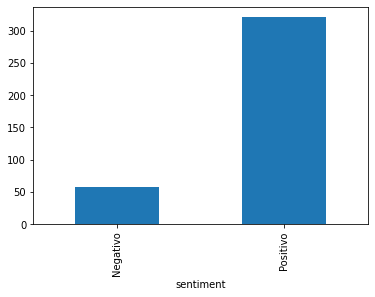

In [ ]:
import matplotlib.pyplot as plt
#sentimientos = df["sentiment"].unique()
df.groupby('sentiment')['location'].nunique().plot(kind='bar')
print(df.groupby(['sentiment']).size())
#df.groupby(['sentiment']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

#df.head(20)
#df["sentiment"].unique()